### Calculate RR using PM2.5

This code calculates the RR from Peng et al., 2021 and GEMM parameter estimates from Burnett et al., 2018. 

RR is calculated for adults >25 using 5-year interval age groups

In [6]:
import geopandas as gpd
import xarray as xr
from cartopy import crs as ccrs
import seaborn as sns; sns.set_theme()
import os
import fiona
import country_converter as coco
import dask
import dask.array as da
import netCDF4 as nc
import regionmask
from matplotlib import cm
import numpy as np
from matplotlib import pyplot as plt
import country_converter as coco
import pyogrio
#pyogrio.set_gdal_config_options({"SHAPE_RESTORE_SHX": "YES"})
import pandas as pd
from cartopy.util import add_cyclic_point
import nc_time_axis
import glob
import cdo
import pandas as pd
import cartopy.feature as cfeature

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
num_ensembles = 10
var_list = 'mda8_o3'.split()
ensembles = {var: [] for var in var_list}
# Loop over each ensemble member
for i in range(1, num_ensembles + 1):
    ensemble_id = f'{i:03d}'  # Format ensemble number as 001, 002, ..., 010
    print(f'Loading ensemble member {ensemble_id}')
    
    # Loop over each variable
    for var in var_list:
        # Construct the file path
        #if var == 'TS':
            # Special case for TS (daily data)
        #    file_path = f'/glade/campaign/cesm/collections/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.{ensemble_id}/atm/proc/tseries/day_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.{ensemble_id}.cam.h1.TS.*.nc'
        file_path = "/glade/derecho/scratch/cindywang625/regrid_O3/ARISE-SAI-1.0/" + ensemble_id + ".O3.nc"
         #file_path = f'/glade/campaign/cesm/collections/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.{ensemble_id}/atm/proc/tseries/month_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.{ensemble_id}.cam.h0.{var}.*.nc'
        
        # Load the dataset and extract the variable
        ds = xr.open_mfdataset(file_path, parallel=True, combine='nested', concat_dim='time')
        ensembles[var].append(ds[var])
        

Loading ensemble member 001
Loading ensemble member 002
Loading ensemble member 003
Loading ensemble member 004
Loading ensemble member 005
Loading ensemble member 006
Loading ensemble member 007
Loading ensemble member 008
Loading ensemble member 009
Loading ensemble member 010


In [4]:
average_ensemble = {}
for var in var_list:
    # Concatenate all ensemble members along a new dimension
    combined = xr.concat(ensembles[var], dim='ensemble')
    # Calculate the mean over the ensemble dimension
    average_ensemble[var] = combined.mean(dim='ensemble')

In [5]:
#base_ssp245 = {}
base_ssp245 = {var: [] for var in var_list}
for i in range(1, num_ensembles + 1):
    ensemble_id = f'{i:03d}'  # Format ensemble number as 001, 002, ..., 010
    print(f'Loading ensemble member {ensemble_id}')
    
    # Loop over each variable
    for var in var_list:
        # Construct the file path
        #if var == 'TS':
            # Special case for TS (daily data)
        #    file_path = f'/glade/campaign/cesm/collections/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.{ensemble_id}/atm/proc/tseries/day_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.{ensemble_id}.cam.h1.TS.*.nc'
        file_path = "/glade/derecho/scratch/cindywang625/regrid_O3/SSP2-4.5_40/" + ensemble_id + ".O3.nc"
        #file_path = f'/glade/campaign/cesm/collections/ARISE-SAI-1.5/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.{ensemble_id}/atm/proc/tseries/month_1/b.e21.BW.f09_g17.SSP245-TSMLT-GAUSS-DEFAULT.{ensemble_id}.cam.h0.{var}.*.nc'
        
        # Load the dataset and extract the variable
        ds = xr.open_mfdataset(file_path, parallel=True, combine='nested', concat_dim='time')
        base_ssp245[var].append(ds[var])

Loading ensemble member 001
Loading ensemble member 002
Loading ensemble member 003
Loading ensemble member 004
Loading ensemble member 005
Loading ensemble member 006
Loading ensemble member 007
Loading ensemble member 008
Loading ensemble member 009
Loading ensemble member 010


In [7]:
average_ensemble_ssp245 = {}
for var in var_list:
    # Concatenate all ensemble members along a new dimension
    combined = xr.concat(base_ssp245[var], dim='ensemble')
    # Calculate the mean over the ensemble dimension
    average_ensemble_ssp245[var] = combined.mean(dim='ensemble')

In [8]:
def global_mean_xarray(ds_XXLL):
    """ 
    Compute the global mean value of the data.
    The data has to have the lat and lon in its dimensions.
    Should not include NaN in Inputs.
    
    Parameters
    ----------
    ds_XXLL   : xarray with lat and lon. ds_XXLL.lat will be 
                used for area weight.

    Returns
    ----------
    tmp_XX    : xarray without lat and lon.
    
    """
    lat = ds_XXLL.coords['lat']        # readin lat
    # global mean
    # compute cos(lat) as a weight function
    weight_lat = np.cos(np.deg2rad(lat))/np.mean(np.cos(np.deg2rad(lat)))
    tmp_XXL = ds_XXLL.mean(dim=['lon'])*weight_lat
    tmp_XX  = tmp_XXL.mean(dim=['lat'])
    return tmp_XX

def weighted_temporal_mean_l(ds, var=None):
    """
    weight by days in each month
    """
    #ds = xr.decode_cf(ds)
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds if var is None else ds[var]

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

## Reiterate for each ensemble member and ensemble average

In [9]:
#Precompute common terms
card_RR = np.log(1.028)/10
resp_RR = np.log(1.06)/10

In [76]:
# DOUBLE CHECK that time = 35 (2035 to 2069; ens 7 and 8 are run up to 2071)
i = 9#<<<<--- change this for each ensemble i=0 to 9
ensemble = '010'#'009'#'010'
#C_base = base_ssp245['mda8_o3'][i][5:]#[20:55]
#C_base = average_ensemble_ssp245['mda8_o3'][:10]

C_em = ensembles['mda8_o3'][i]
#C_em = average_ensemble['mda8_o3']

In [77]:
calcs = xr.Dataset()
#calcs.coords['age'] = (('age'), list(age_theta))
calcs.coords['time'] = (('time'), C_em['time'].data)

calcs.coords['lat']  = (('lat'),C_em.coords['lat'].values)
calcs.coords['lon']  = (('lon'),C_em.coords['lon'].values)
#calcs['RR']      = (('age','lat','lon'),RR)

In [78]:
RR_card_em = xr.where((C_em - 40) <= 0, 1, np.exp(-card_RR * (C_em - 40)))
#RR_card_base = xr.where((C_base - 40) <= 0, 1, np.exp(-card_RR * (C_base - 40)))

RR_resp_em = xr.where((C_em - 32.4) <= 0, 1, np.exp(-resp_RR * (C_em - 32.4)))
#RR_resp_base = xr.where((C_base - 32.4) <= 0, 1, np.exp(-resp_RR * (C_base - 32.4)))

In [79]:
calcs['RR_card_em']      = (('time','lat','lon'),RR_card_em.values)
#calcs['RR_card_base']      = (('time','lat','lon'),RR_card_base.values)
#calcs['RR_card_diff'] = (('time','lat','lon'),RR_card_base.values-RR_card_em.values)


In [80]:
calcs['RR_resp_em']      = (('time','lat','lon'),RR_resp_em.values)
#calcs['RR_resp_base']      = (('time','lat','lon'),RR_resp_base.values)
#calcs['RR_resp_diff']      = (('time','lat','lon'),RR_resp_base.values-RR_resp_em.values)

In [81]:
calcs.to_netcdf(f'/glade/derecho/scratch/cindywang625/RR_ozone/ARISE-SAI-1.0/{ensemble}.nc')
#calcs.to_netcdf(f'/glade/derecho/scratch/cindywang625/RR_ozone/avg_RR.nc')


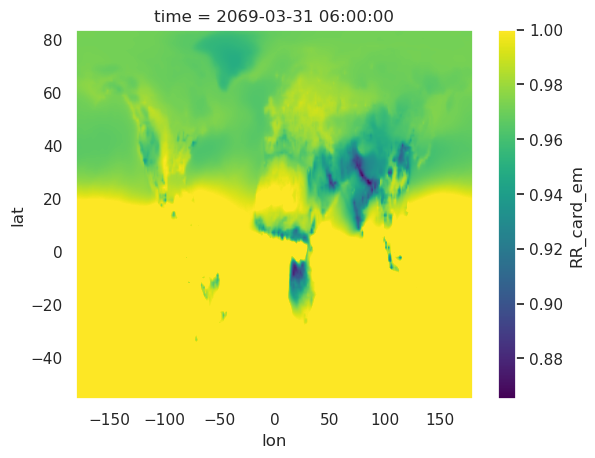

In [18]:
xr.open_mfdataset('/glade/derecho/scratch/cindywang625/RR_ozone/ARISE-SAI-1.0/avg_RR.nc')['RR_card_em'][-1].plot()

